## Example notebook to show how to use graph builder package

#### Importing data

Data can be extracted from `ExpressionSet`s. We builds a data structure of the following form:
    
- Dict{ function_name : Hexel} where Hexel has as attributes function, best_pairings, description, github commit and color.


In [5]:
from kymata.datasets.sample import KymataMirror2023Q3Dataset
from kymata.entities.expression import HexelExpressionSet
from kymata.ippm.data_tools import stem_plot, build_hexel_dict_from_expression_set, convert_to_power10
from kymata.ippm.denoiser import DBSCAN, MeanShift
from kymata.ippm.builder import build_ippm_graph
from kymata.ippm.plot import plot_ippm

In [6]:
expression_set: HexelExpressionSet = KymataMirror2023Q3Dataset().to_expressionset()
hexels = build_hexel_dict_from_expression_set(expression_set)
hexels = convert_to_power10(hexels)

Data root set at /Users/administration/Github/kymata-toolbox/kymata-toolbox-data.
Consider setting this as environmental variable KYMATA_DATA_ROOT to ensure it's reused next time.
Hint: $> KYMATA_DATA_ROOT="/Users/administration/Github/kymata-toolbox/kymata-toolbox-data"
Local file already exists: /Users/administration/Github/kymata-toolbox/kymata-toolbox-data/tutorial_nkg_data/kymata_mirror_Q3_2023/kymata_mirror_Q3_2023_expression_endtable.nkg


/Users/administration/Github/kymata-toolbox/kymata/io/nkg.py:144: UserWarning: This file uses an old format. Please consider re-saving the data to avoid future incompatibility.
  warn("This file uses an old format. Please consider re-saving the data to avoid future incompatibility.")


#### Plotting data

stem_plot is a useful function to plot all of the data in hexels. Takes the hexels data structure illustrated above as input along with title.

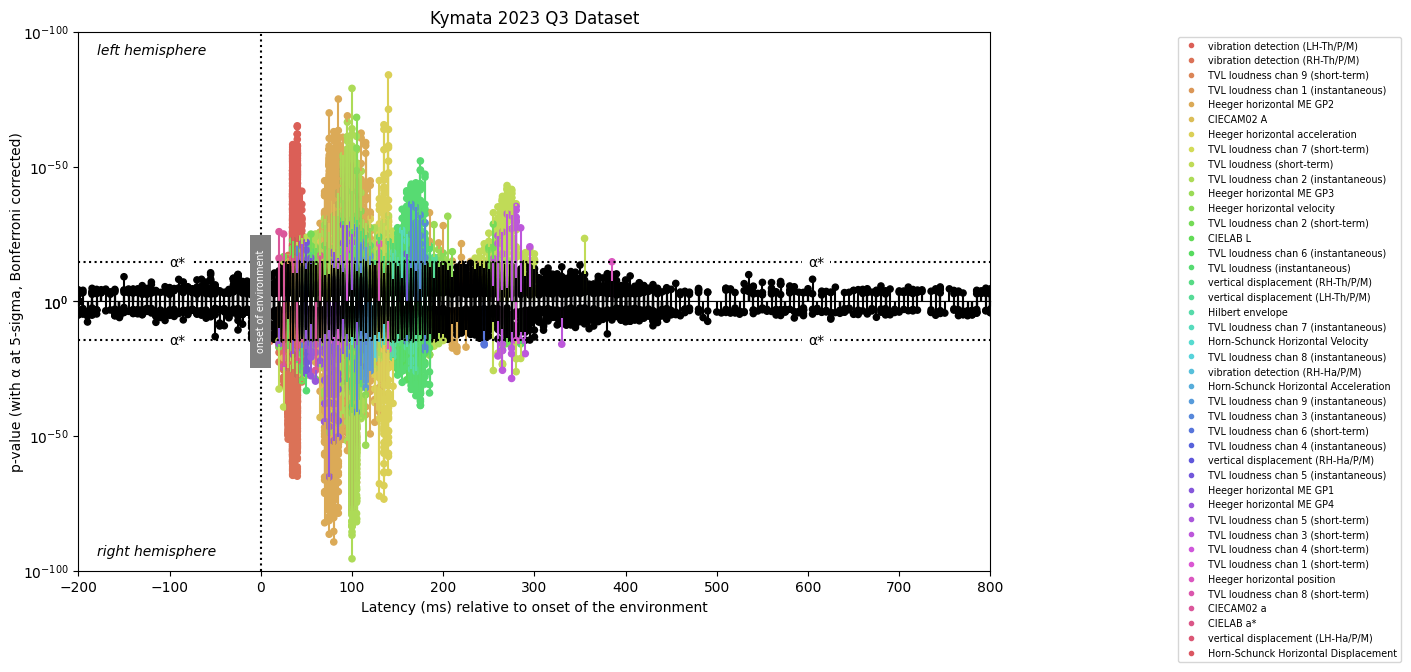

In [7]:
stem_plot(hexels, 'Kymata 2023 Q3 Dataset')

#### Denoising

The first iteration of the denoiser is a max pooling strategy. It partitions the x-axis into bins and looks for clusters of spikes in each bin for each function. If a cluster is found, it takes the maximum. The returned hexels have the best_pairings reduced significantly.

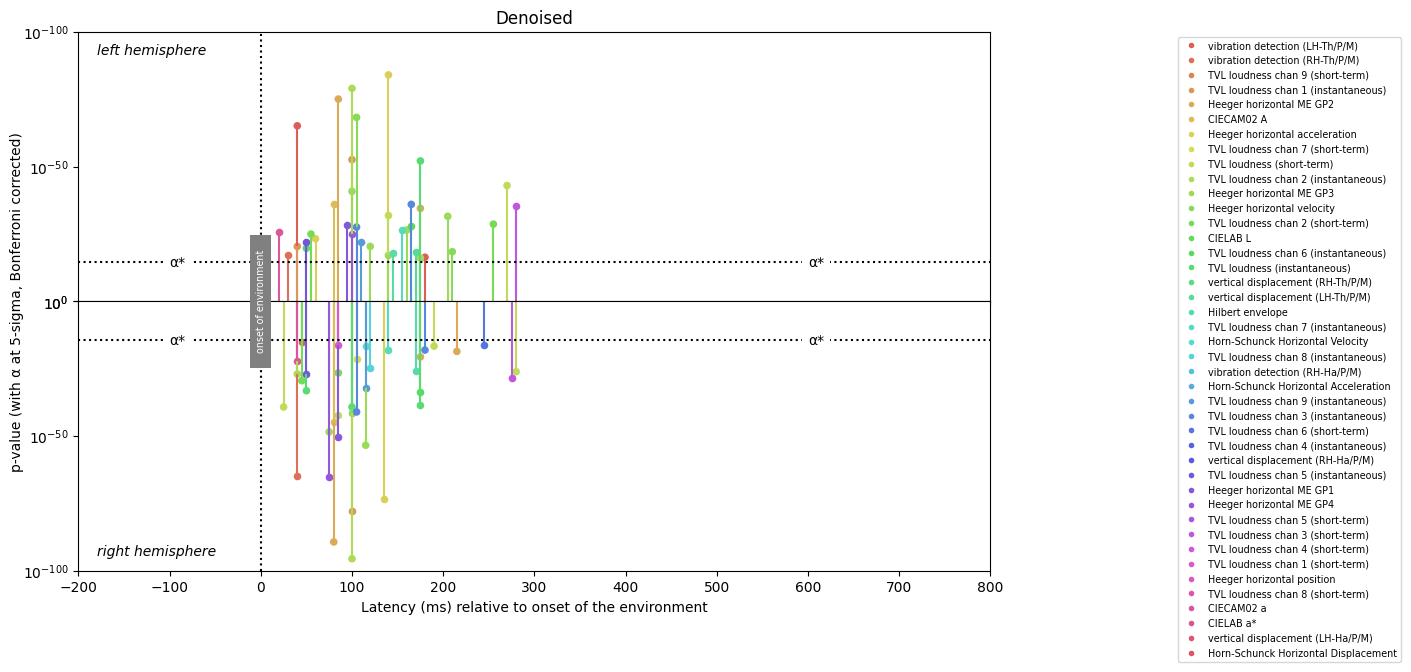

In [8]:
'''
    For more details on each algorithm, check the denoiser.py file and ctrl-f search for the names. If further details are required, you can check the relevant sklearn page too.
    Strategies
    ----------
        - Max Pooler : hyperparameters = [num_clusters, bin_sz]
                       num_clusters is the threshold for a bin to be considered a cluster. default=15
                       bin_sz is the size of the bin in ms. default = 25
        - Gaussian Mixture : hyperparameters = [max_gaussians, covariance_type, max_iter, n_init, init_params, random_state]
                       max_gaussians indicates the maximum number of gaussians in the mixture. default = 5.
                       covariance_type = [full, tied, diag, spherical]. default = full
                                       specifies the covariance matrix of the Gaussians
                       max_iter is the # of iterations til stop. default = 1000.
                       n_init = # of initialisations. default = 8
                       init_params = [kmeans, k-means++, random, random_from_data]. default = kmeans
                                    specifies how to initialise the parameters
                       random_state is a seed. Set it for reproducibility. default = None
        - DBSCAN : hyperparameters = [eps, min_samples, metric, metric_params, algorithm, leaf_size, n_jobs]
                       eps is the maximum distance between two samples to be considered in the neighbourhood.
                           default = 10.
                       min_samples the number of samples in a neighbourhood for a point to be a core point.
                           default = 2
                       metric used to compute distance. default = euclidean. check sklearn.metrics.pairwise_distance
                       metric_params additional params for metric. default = None.
                       algorithm = [auto, ball_tree, kd_tree, brute]. default = auto
                                 the algorithm used by nearestneighbours to compute distance.
                       leaf_size leaf size for ball_tree or kd_tree. default=30
                       n_jobs is the number of processors to use. default = -1.
        - Mean Shift : hyperparameters = [bandwidth, seeds, min_bin_freq, cluster_all, n_jobs]
                       bandwidth the bandwidth of the kernel. default = 30
                       seeds seeds used to initialise kernels. default = None
                       min_bin_freq accept only those bins with at least min_bin_freq points. default = 1
                       cluster_all false means to ignore anomalies. default = False
                       n_jobs is the number of processors to use. default = -1.
    the inputs for the strategy parameters are [max pooler, gaussian mixture, dbscan, mean shift].
'''
# algos : denoiser.[MaxPooler, DBSCAN, GMM, MeanShift]

clusterer = DBSCAN()
denoised_hexels = clusterer.cluster(hexels, 'rightHemisphere') # rightHemisphere or leftHemisphere.
denoised_hexels = clusterer.cluster(denoised_hexels, 'leftHemisphere')
stem_plot(denoised_hexels, 'Denoised')

#### Generating the Directed Graph

To generate a graph, we need relations between functions, in the form of a function hierarchy. It is 
a dictionary containing function names with their children. Furthermore, this dictionary needs to
contain the input function too. 

An additional input is the list of input functions. This is so we can differentiate between the spikes and inputs. Finally, it also takes the hemisphere and and title as input.

The result graph has as the y-axis the latency of spike, x-axis as class partitions, and node sizes as the magnitude of the spike. 

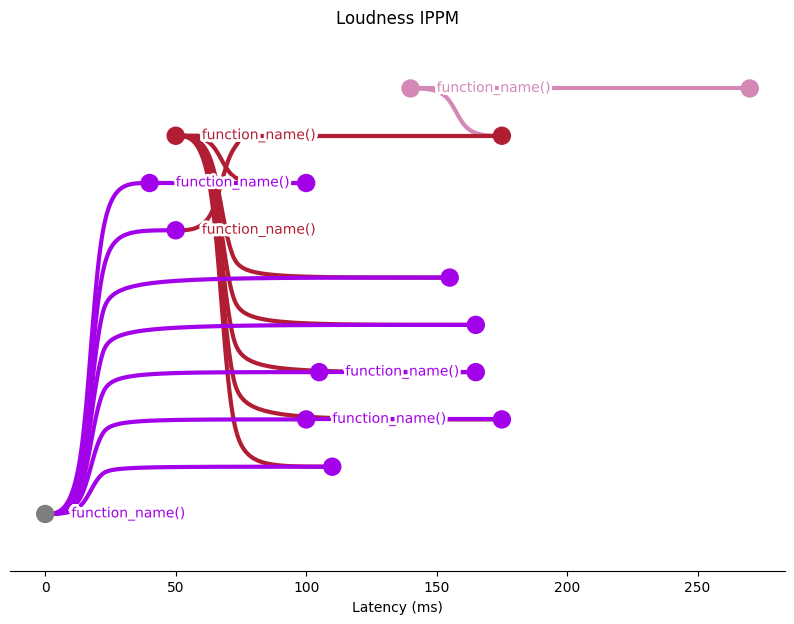

In [9]:
inputs = ['input_cochlear']
function_hier = {
        # assumption: we have a list of functions and their children function
        'TVL loudness (short-term)' : ['TVL loudness (instantaneous)'],
        'TVL loudness (instantaneous)' : [
                'TVL loudness chan 1 (instantaneous)',
                'TVL loudness chan 2 (instantaneous)',
                'TVL loudness chan 3 (instantaneous)',
                'TVL loudness chan 4 (instantaneous)',
                'TVL loudness chan 5 (instantaneous)',
                'TVL loudness chan 6 (instantaneous)',
                'TVL loudness chan 7 (instantaneous)',
                'TVL loudness chan 8 (instantaneous)',
                'TVL loudness chan 9 (instantaneous)'],
        'TVL loudness chan 1 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 2 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 3 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 4 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 5 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 6 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 7 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 8 (instantaneous)' : ['input_cochlear'],
        'TVL loudness chan 9 (instantaneous)' : ['input_cochlear'],
        'input_cochlear' : []
    }
function_colour_overrides = {
        # Functions and their colours to match the figures
        'TVL loudness (short-term)' : '#d388b5',
        'TVL loudness (instantaneous)' : '#b11e34',
        'TVL loudness chan 1 (instantaneous)' : '#a201e9',
        'TVL loudness chan 2 (instantaneous)' : '#a201e9',
        'TVL loudness chan 3 (instantaneous)' : '#a201e9',
        'TVL loudness chan 4 (instantaneous)' : '#a201e9',
        'TVL loudness chan 5 (instantaneous)' : '#a201e9',
        'TVL loudness chan 6 (instantaneous)' : '#a201e9',
        'TVL loudness chan 7 (instantaneous)' : '#a201e9',
        'TVL loudness chan 8 (instantaneous)' : '#a201e9',
        'TVL loudness chan 9 (instantaneous)' : '#a201e9',
        'input_cochlear' : '#7e7e7e'
    }
graph_dict = build_ippm_graph(denoised_hexels, function_hier, inputs, 'leftHemisphere')
plot_ippm(graph=graph_dict, colors=function_colour_overrides, title='Loudness IPPM', figheight=7, figwidth=10)

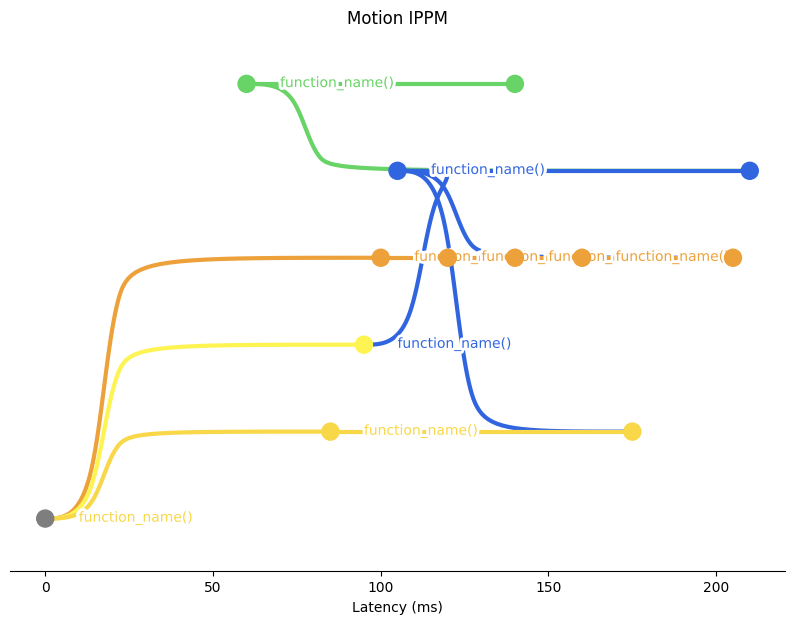

In [10]:
inputs = ['input_photoreceptors']
function_hier = {
        'Heeger horizontal acceleration' : ['Heeger horizontal velocity'],
        'Heeger horizontal velocity' : [
                'Heeger horizontal ME GP1', 
                'Heeger horizontal ME GP2', 
                'Heeger horizontal ME GP3'],
        'Heeger horizontal ME GP1' : ['input_photoreceptors'],
        'Heeger horizontal ME GP2' : ['input_photoreceptors'],
        'Heeger horizontal ME GP3' : ['input_photoreceptors'],
        'input_photoreceptors' : []
    }
function_colour_overrides = {
        # Functions and their colours to match the figures
        'Heeger horizontal acceleration' : '#68d366',
        'Heeger horizontal velocity' : '#3165e0',
        'Heeger horizontal ME GP1' : '#fdf351',
        'Heeger horizontal ME GP2' : '#f8d748',
        'Heeger horizontal ME GP3' : '#eda13a',
        'Heeger horizontal ME GP4' : '#ed732e',
        'input_photoreceptors' : '#7e7e7e'
    }
graph_dict = build_ippm_graph(denoised_hexels, function_hier, inputs, 'leftHemisphere')
plot_ippm(graph_dict, function_colour_overrides, title='Motion IPPM', figheight=7, figwidth=10)